In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

tf.random.set_seed(12) # we set our seed so that when we run the for loop to intialize an LSTM model, we have the same weights (taking away luck/variability)

### Cross Validating Our Best Model Results

In [2]:
train_data = pd.read_csv('train_scaled.csv')
test_data = pd.read_csv('test_scaled.csv')

train_dates = {}
test_dates = {}
all_dates = {}

for ticker in train_data["TickerName"].unique():

    train_dates[ticker] = train_data[train_data["TickerName"] == ticker]['date'][16:]
    test_dates[ticker] = test_data[test_data["TickerName"] == ticker]['date'][:len(test_data[test_data["TickerName"] == ticker]['date']) - 16]
    all_dates[ticker] = pd.concat([train_dates[ticker], test_dates[ticker]], ignore_index=True)

train_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
train_data.head()

test_data.drop(["date", "open", "high", "low"], axis=1, inplace=True)
test_data.head()

formatted_data = {}
all_formatted_data = {}

sequence_length = 15
for ticker in train_data["TickerName"].unique():
    formatted_data[ticker] = []
    all_formatted_data[ticker] = []

    temp_train_data = train_data[train_data["TickerName"] == ticker].drop(["TickerName"], axis=1)
    temp_train_data = temp_train_data.values
    X, y = [], []
    for i in range(len(temp_train_data) - sequence_length - 1):
        X.append(temp_train_data[i:i + sequence_length, :])
        y.append(temp_train_data[i + sequence_length + 1, 0])

    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)

    X, y = [], []
    temp_test_data = test_data[test_data["TickerName"] == ticker].drop(["TickerName"], axis=1).values
    for i in range(len(temp_test_data) - sequence_length - 1):
        X.append(temp_test_data[i:i + sequence_length, :])
        y.append(temp_test_data[i + sequence_length + 1, 0])
    X, y = np.array(X), np.array(y)
    formatted_data[ticker].append([X, y])
    print(ticker, X.shape, y.shape)
    
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][0], formatted_data[ticker][1][0]], axis = 0))
    all_formatted_data[ticker].append(np.concatenate([formatted_data[ticker][0][1], formatted_data[ticker][1][1]], axis = 0))
    print(ticker, all_formatted_data[ticker][0].shape, all_formatted_data[ticker][1].shape)
    
    print(ticker, "done")

KSCP (285, 15, 3) (285,)
KSCP (113, 15, 3) (113,)
KSCP (398, 15, 3) (398,)
KSCP done
GCT (187, 15, 3) (187,)
GCT (71, 15, 3) (71,)
GCT (258, 15, 3) (258,)
GCT done
ASST (105, 15, 3) (105,)
ASST (37, 15, 3) (37,)
ASST (142, 15, 3) (142,)
ASST done


In [3]:
def LSTM_model(nodes, num_layers):
    
    model = Sequential()

    model.add(LSTM(units=nodes, return_sequences=True, input_shape=(15, 3)))
    model.add(Dropout(0.2))
    
    for i in range(num_layers - 1):
        model.add(LSTM(units = 50, return_sequences=True))
        model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    model.compile(
    optimizer='adam', 
    loss='mean_squared_error')

    return model

### Referencing Our Grid Search Our Best Model Metrics Are...
- The best hyperparameters for KSCP's model are (50 epochs, 4 layers, 100 nodes, 20 batch size)
- The best hyperparamters for the other ticker models was (50 epochs, 5 layers, 100 nodes, 20 batch size)

In [6]:
cv_results = {}

for ticker in train_data["TickerName"].unique():
    cv_results[ticker] = {}
    for i in range(1,11):    # only 10 because of computational constraints
        temp_data = formatted_data[ticker][0][0][:len(formatted_data[ticker][0][0]) - i]
        temp_labels =formatted_data[ticker][0][1][:len(formatted_data[ticker][0][1]) - i]
        
        if ticker == "KSCP":
            model = LSTM_model(100, 4)
        else:
            model = LSTM_model(100, 5)
        
        model.fit(temp_data, temp_labels, epochs = 50, batch_size = 20, verbose=0)
        predicted_2 = model.predict(formatted_data[ticker][0][0][:len(formatted_data[ticker][0][0]) - i + 2])[-1]
        actual_2 = formatted_data[ticker][0][1][:len(formatted_data[ticker][0][1]) - i + 2][-1]
        
        cv_results[ticker][i] = [model.evaluate(formatted_data[ticker][0][0], formatted_data[ticker][0][1], verbose=0), predicted_2, actual_2]

4/4 [==============================] - 1s 10ms/step


In [8]:
MSE = {}
for ticker in train_data["TickerName"].unique():
    MSE[ticker] = []
    for i in range(1, 11):
        MSE[ticker].append(cv_results[ticker][i][0])

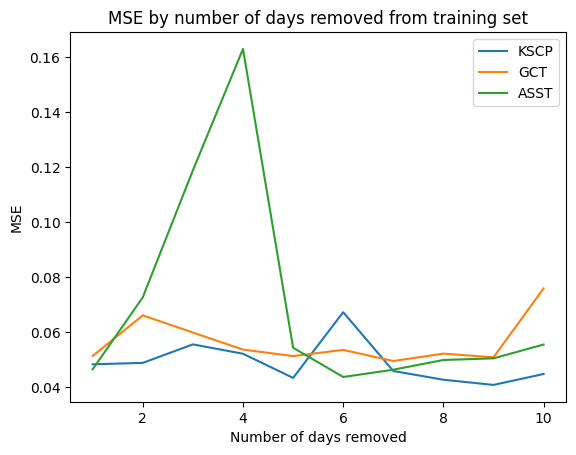

In [9]:
for ticker in train_data["TickerName"].unique():
    plt.plot(cv_results[ticker].keys(), MSE[ticker], label = ticker)
    plt.title("MSE by number of days removed from training set")
    plt.xlabel("Number of days removed")
    plt.ylabel("MSE")
    plt.legend()

In [11]:
residuals = {}
for ticker in train_data["TickerName"].unique():
    residuals[ticker] = []
    for i in range(1, 11):
        residuals[ticker].append(cv_results[ticker][i][1][0] - cv_results[ticker][i][2])

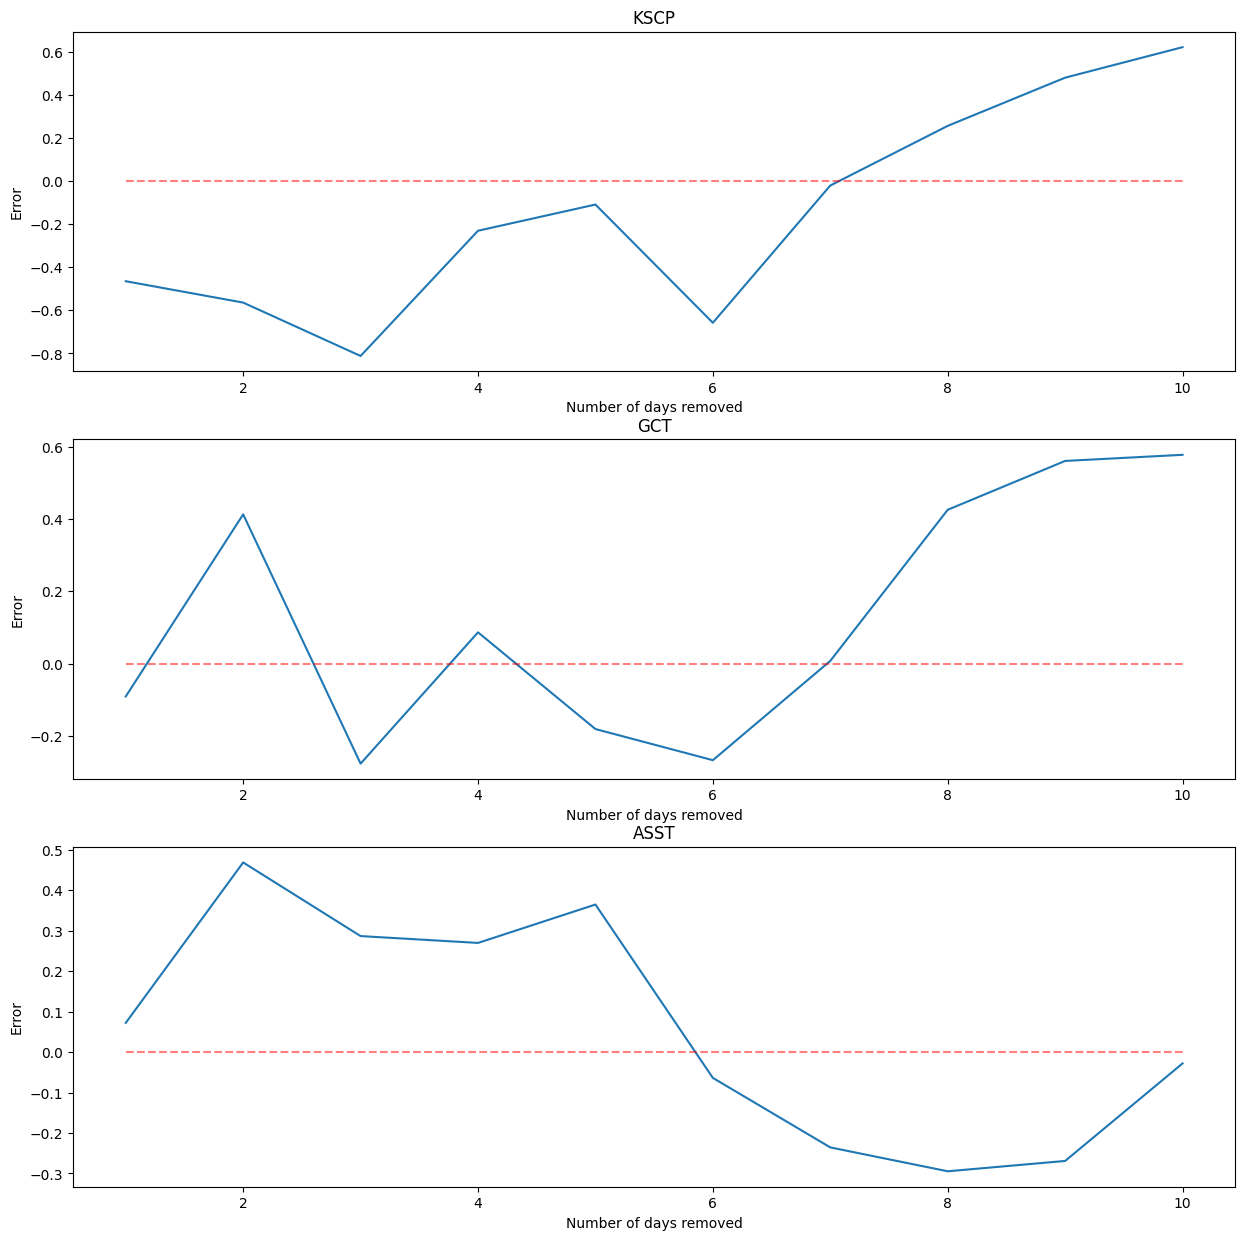

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
for i, ticker in enumerate(train_data["TickerName"].unique()):
    ax = axes[i]

    ax.plot(cv_results[ticker].keys(), residuals[ticker], label = ticker)
    ax.plot(cv_results[ticker].keys(), np.zeros(len(range(11, 1, -1))), color = "r", linestyle='--', alpha = 0.5, label = "y = 0")
    ax.set_title(ticker)
    ax.set_xlabel("Number of days removed")
    ax.set_ylabel("Error")

### Analyzing the LSTM CV results
- The loss/MSE values are pretty similar to the ones we got for the model when we trained it on the full training data.
- We want this because we want to know that our predictions will be reliable in a realistic situation where we will constantly be training a model each day similar to the structure of this.
- 

In [ ]:
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

optimal_fit = {}

for i in ["KSCP", "GCT", "ASST"]:
    temporary = train_scaled[train_scaled["TickerName"] == i]
    model = pm.auto_arima(temporary["close"], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    optimal_fit[i] = model

### Cross Validation of ARMA model

In [ ]:
acc_cv_results = {}
cv_results2 = {}
cv_aic = {}

for ticker in ["KSCP", "GCT", "ASST"]:
    temporary_data = train_scaled[train_scaled["TickerName"] == ticker]

    cv_results2[ticker] = []
    acc_cv_results[ticker] = []
    cv_aic[ticker] = []
    
    
    for i in range(17, 2, -1):
        if ticker == "ASST":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose = False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
                


        elif ticker == "GCT":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose = False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
               


        elif ticker == "KSCP":
            if adfuller(temporary_data["close"][:len(temporary_data["close"]) - i])[1] <= 0.05:
                model = pm.auto_arima(temporary_data["close"][:len(temporary_data["close"]) - i], start_p=1, start_q=1,
                           test='adf',
                           m=1,
                           d=None, 
                           seasonal=False,
                           start_P=0, 
                           D=0, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           verbose=False)
                pred = model.predict(n_periods=2)
                cv_results2[ticker].append(pred)
                acc_cv_results[ticker].append(temporary_data[:len(temporary_data["close"]) - i + 2].iloc[-1])
                cv_aic[ticker].append(model.aic())
                


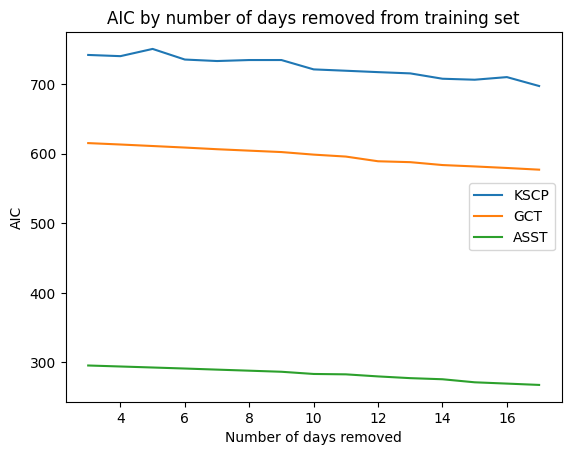

In [58]:
for ticker in ["KSCP", "GCT", "ASST"]:
    plt.plot(range(17, 2, -1), cv_aic[ticker], label = ticker)
    plt.title("AIC by number of days removed from training set")
    plt.xlabel("Number of days removed")
    plt.ylabel("AIC")
    plt.legend()

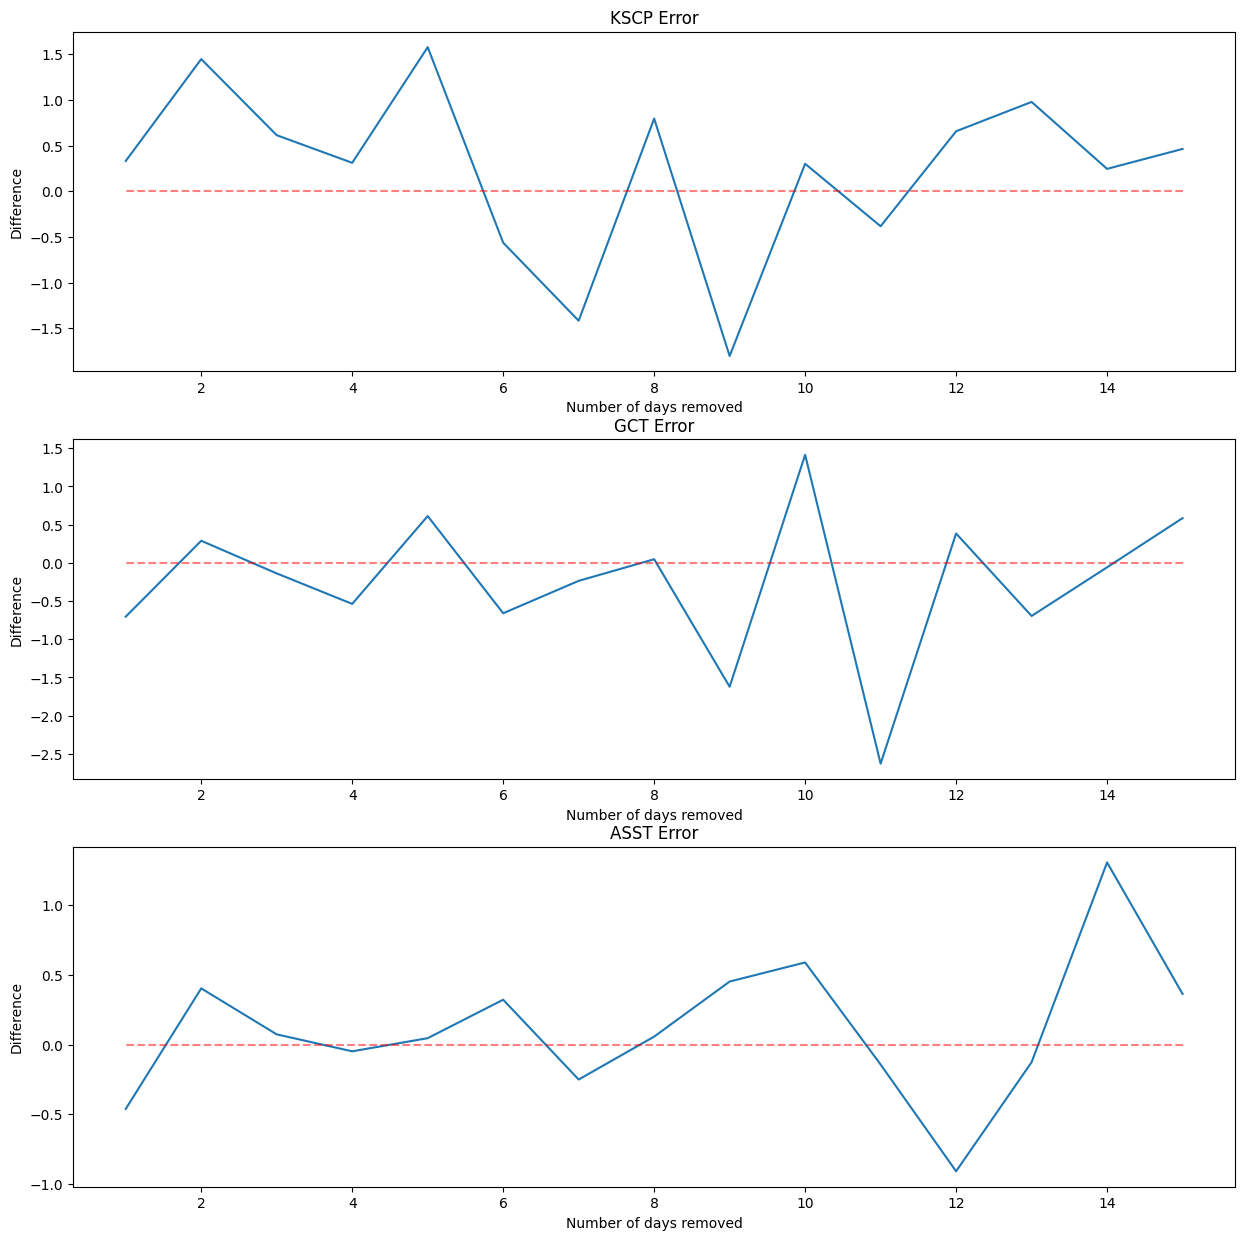

In [90]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

for i, ticker in enumerate(["KSCP", "GCT", "ASST"]):
    prediction_values = []
    acc_vals = []
    for idx in range(len(cv_results2[ticker])):
        prediction_values.append(cv_results2[ticker][idx].iloc[-1])
        acc_vals.append(acc_cv_results[ticker][idx]["close"])
    
    axs[i].plot(range(15, 0, -1), np.array(acc_vals) - np.array(prediction_values))
    axs[i].plot(range(15, 0, -1), np.zeros(len(range(15, 0, -1))), color = "r", linestyle='--', alpha = 0.5)
    axs[i].set_title(f"{ticker} Error")
    axs[i].set_xlabel("Number of days removed")
    axs[i].set_ylabel("Difference")

In [5]:
fitted_values = {}

for i in ["KSCP", "GCT", "ASST"]:
    temporary_train = train_scaled[train_scaled["TickerName"] == i]
    temporary_test = test_scaled[test_scaled["TickerName"] == i]
    model = optimal_fit[i]
    fitted_train = model.predict_in_sample()
    fitted_test = model.predict(temporary_test.shape[0])
    fitted_values[i] = [fitted_train, fitted_test, pd.concat([pd.Series(fitted_train), pd.Series(fitted_test)], ignore_index=True)]

/Users/andrewlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/andrewlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/andrewlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/andrewlee/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported 

In [6]:
for i in ["KSCP", "GCT", "ASST"]:
    print(f"{i} in sample MSE: {np.mean(np.subtract(fitted_values[i][0], train_scaled[train_scaled['TickerName'] == i]['close'])**2)}")
    print(f"{i} TEST MSE: {np.mean(np.subtract(fitted_values[i][1], np.array(test_scaled[test_scaled['TickerName'] == i]['close']))**2)}")

KSCP in sample MSE: 0.9343964681880498
KSCP TEST MSE: 0.6922533493377858
GCT in sample MSE: 2.2473381583256513
GCT TEST MSE: 0.26259214398085573
ASST in sample MSE: 0.6610881516064475
ASST TEST MSE: 0.4689281884551199


### Performance on the Test Data

In [7]:
test_results = {}

for ticker in train_data["TickerName"].unique():
    temp_data = formatted_data[ticker][0][0]
    temp_labels = formatted_data[ticker][0][1]
    
    if ticker == "KSCP":
        model = LSTM_model(100, 4)
    else:
        model = LSTM_model(100, 5)
    
    model.fit(temp_data, temp_labels, epochs = 50, batch_size = 20, verbose=0)
    
    test_results[ticker] = [model.evaluate(formatted_data[ticker][1][0], formatted_data[ticker][1][1], verbose=0), model.predict(formatted_data[ticker][0][0]), model.predict(formatted_data[ticker][1][0])]

2/2 [==============================] - 0s 11ms/step


In [8]:

for i, ticker in enumerate(train_data["TickerName"].unique()):    
    print(f"{ticker} TEST MSE: {np.mean(np.subtract(np.array(test_results[ticker][2]), np.array(formatted_data[ticker][1][1]).reshape(test_results[ticker][2].shape))**2)}")
    print(f"{ticker} IN Sample MSE: {np.mean(np.subtract(np.array(test_results[ticker][1]), np.array(formatted_data[ticker][0][1]).reshape(test_results[ticker][1].shape))**2)}")

KSCP TEST MSE: 0.3425599759818968
KSCP IN Sample MSE: 0.04160892666685394
GCT TEST MSE: 0.26065912077909353
GCT IN Sample MSE: 0.058891559949822696
ASST TEST MSE: 0.34660812788469014
ASST IN Sample MSE: 0.031104701065130587


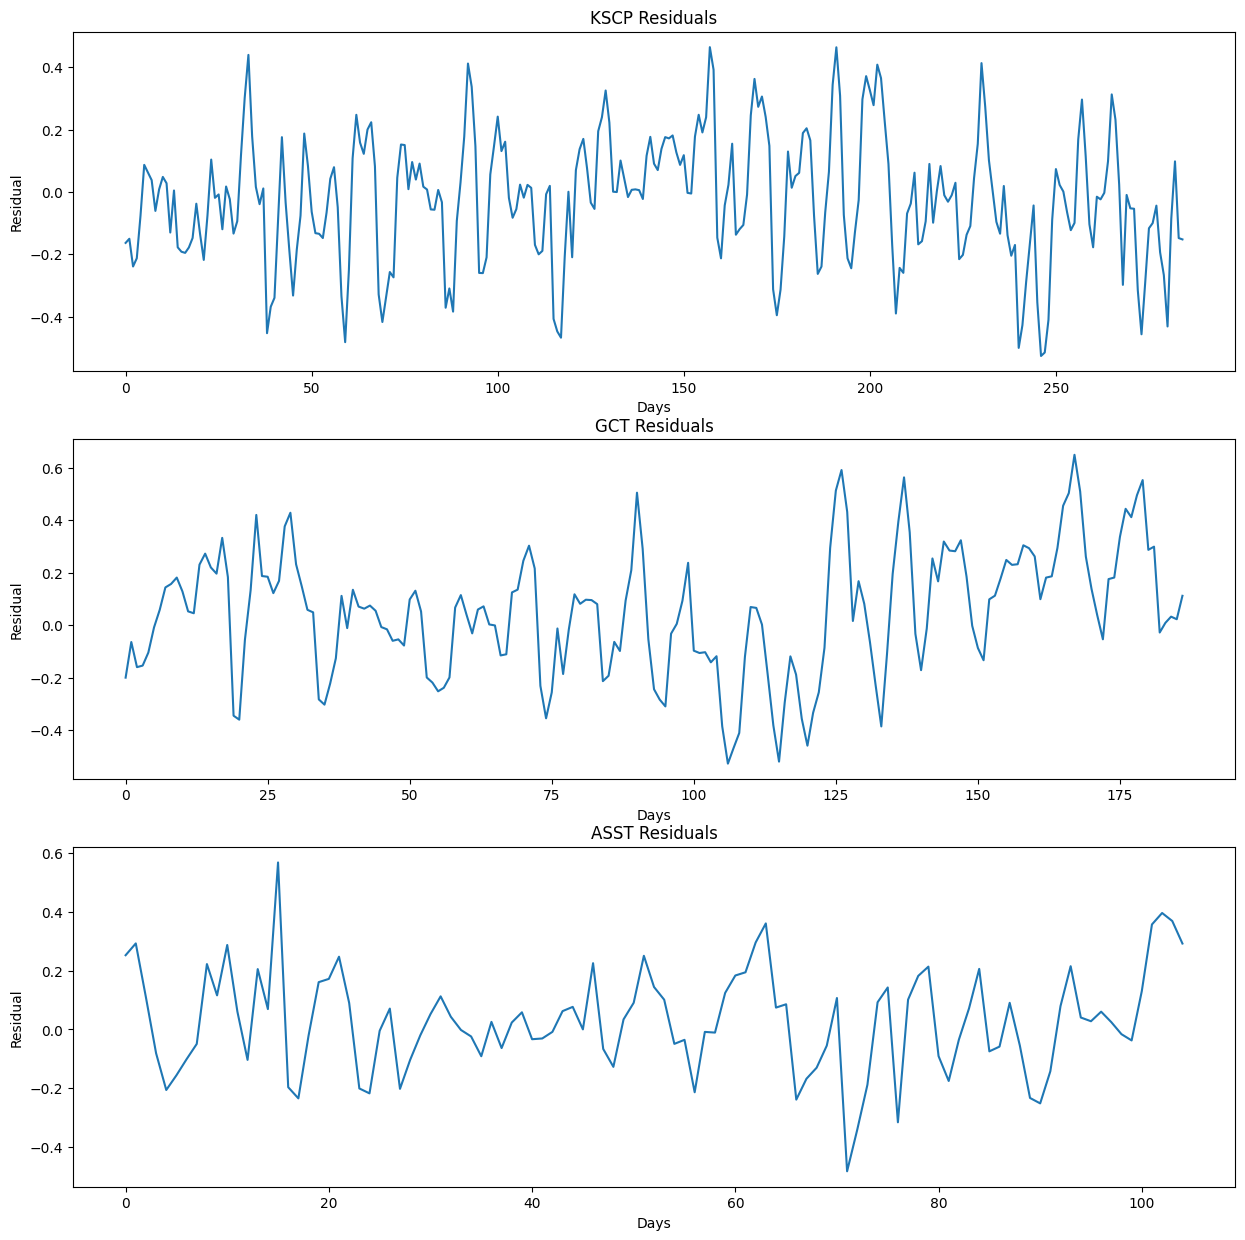

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
for index, ticker in enumerate(train_data["TickerName"].unique()):
    ax = axes[index]
    ax.plot(np.subtract(np.array(test_results[ticker][1]), np.array(formatted_data[ticker][0][1]).reshape(test_results[ticker][1].shape)))
    ax.set_xlabel("Days")
    ax.set_ylabel("Residual")
    ax.set_title(f"{ticker} Residuals")

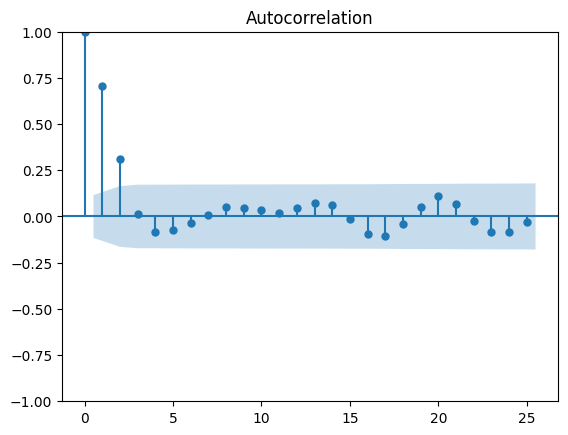

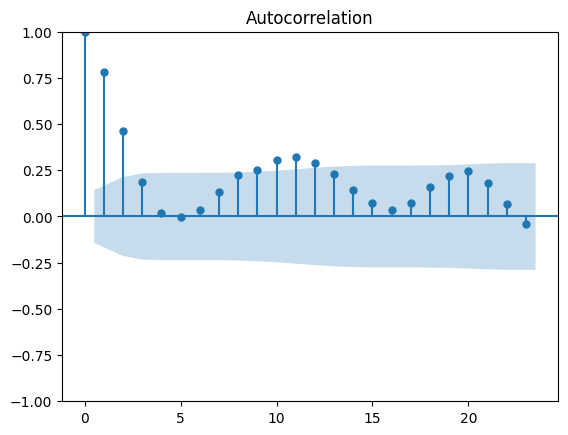

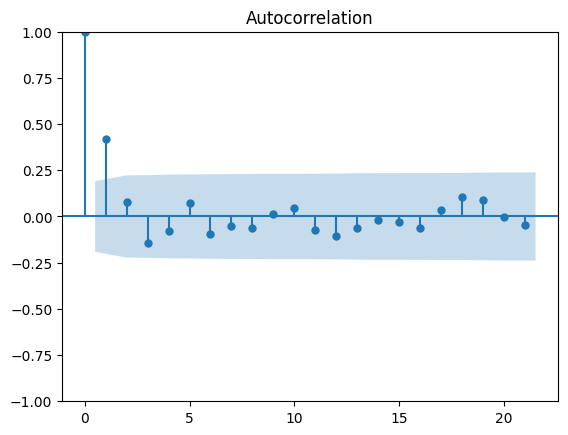

In [13]:
import statsmodels.graphics.tsaplots as tsa

for ticker in train_data["TickerName"].unique():
    tsa.plot_acf(np.subtract(np.array(test_results[ticker][1]), np.array(formatted_data[ticker][0][1]).reshape(test_results[ticker][1].shape)))